In [1]:
from flash_attn.replace import replace_attn_with_flash_attn
print(replace_attn_with_flash_attn)

ModuleNotFoundError: No module named 'flash_attn.replace'

In [ ]:


import json
import time
import numpy as np
from pathlib import Path
from tqdm import tqdm
from datasets import load_dataset  # ensure load_dataset is defined
from transformers import (
    AutoModelForCausalLM, AutoModelForSequenceClassification,
    AutoTokenizer, BitsAndBytesConfig
)
import torch
model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"

# load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name, torch_dtype=torch.float16, device_map="auto"  # GPU
)
model.eval()

# prompt
prompt = "What is computer?"
formatted_prompt = f"""
<｜begin▁of▁sentence｜><｜User｜>{prompt}<｜Assistant｜><think>
"""

inputs = tokenizer(formatted_prompt, return_tensors="pt").to(model.device)

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=512,
        do_sample=False,
        temperature=0.5,
        top_p= 0.9,
    )

generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.



<｜User｜>What is computer?<｜Assistant｜><think>
Okay, so I need to figure out what a computer is. I've heard the term before, but I'm not exactly sure what it means. Let me start by breaking it down. I know computers are used for a lot of things, like running software, handling data, and maybe even playing games. But what


In [6]:

import contextlib
import io

ans = 'def remove_Occ(s, ch):\n    s = s.lstrip(ch)\n    s = s.rstrip(ch)\n    return s'
test = ['assert remove_Occ("hello","l") == "heo"',
 'assert remove_Occ("abcda","a") == "bcd"',
 'assert remove_Occ("PHP","P") == "H"']

def evaluate_generated_code(generated_code, test_cases):
    """
    Evaluate generated code by executing it and running provided test cases.

    Args:
        generated_code (str): Generated Python function code
        test_cases (list of str): List of test expressions to evaluate

    Returns:
        bool: True if all test cases pass, False otherwise
    """
    try:
        # Prepare an isolated execution environment
        exec_globals = {}
        exec_locals = {}

        # Execute the generated code
        with contextlib.redirect_stdout(io.StringIO()):
            exec(generated_code, exec_globals, exec_locals)

        # Now run all test cases
        for test in test_cases:
            # Each test is a string like "assert my_func(5) == 120"
            with contextlib.redirect_stdout(io.StringIO()):
                exec(test, exec_globals, exec_locals)

        return True  # All tests passed

    except Exception as e:
        # If any error happens (syntax error, wrong output, etc.), the function is incorrect
        return False

evaluate_generated_code(ans,test)

False

In [61]:
import re
import ast
# def extract_clean_function_code_from_output(text: str):
#     """
#     从 LLM 输出中提取有效函数定义。优先解析 [BEGIN]... 区块，
#     如果不存在，则尝试提取 markdown ```python``` 块或 def 函数块。
#     返回 AST 校验通过的函数代码（只提取 FunctionDef，不含调用语句）。
#     """
#     def extract_first_def_block(code: str) -> str:
#         """从代码段中提取第一个 def 函数定义（不包括调用、print、解释）"""
#         lines = code.strip().splitlines()
#         def_block = []
#         inside_func = False

#         for line in lines:
#             if re.match(r"^def\s+\w+\(.*\):", line):  # 函数定义开始
#                 inside_func = True
#                 def_block.append(line)
#             elif inside_func and (line.startswith("    ") or line.startswith("\t")):
#                 def_block.append(line)
#             elif inside_func:
#                 break  # 函数结束
#         return "\n".join(def_block)

#     # Step 1: 尝试 [BEGIN]... 区块
#     begin_match = re.search(r"\[BEGIN\]<｜Assistant｜><think>\n(.*?)\n\[END\]<｜Assistant｜><think>", text, re.DOTALL)
#     if begin_match:
#         raw_block = begin_match.group(1).strip()
#         code_block = extract_first_def_block(raw_block)
#     else:
#         # Step 2: 尝试 ```python 块
#         md_match = re.search(r"```python\n(.*?)```", text, re.DOTALL | re.IGNORECASE)
#         if md_match:
#             code_block = extract_first_def_block(md_match.group(1))
#         else:
#             # Step 3: fallback - 第一个 def 函数
#             def_match = re.search(r"(def\s+\w+\(.*?\):(?:\n(?: {4}|\t).*)*)", text, re.DOTALL)
#             if def_match:
#                 code_block = def_match.group(1).strip()
#             else:
#                 return "code block not found"

#     # Step 4: AST 语法校验
#     try:
#         tree = ast.parse(code_block)
#         funcs = [node for node in tree.body if isinstance(node, ast.FunctionDef)]
#         return "\n\n".join([ast.unparse(func) for func in funcs]) if funcs else None
#     except Exception as e:
#         print("AST ERROR INPUT:\n", code_block)
#         return "ast grammar error!"


# import re
# import ast

def extract_clean_function_code_from_output(text: str) -> str:
    """
    从 LLM 输出中提取第一个有效函数定义。优先解析 [BEGIN]... 区块，
    如果不存在，则尝试提取 markdown ```python``` 块或 def 函数块。
    返回 AST 校验通过的第一个函数代码。
    """

    def extract_all_def_blocks(raw: str) -> list[str]:
        blocks = []
        lines = raw.strip().splitlines()
        current_block = []
        inside_func = False

        for line in lines:
            if re.match(r"^def\s+\w+\(.*\):", line):
                if current_block:
                    blocks.append("\n".join(current_block))
                    current_block = []
                inside_func = True
                current_block.append(line)
            elif inside_func and (line.startswith("    ") or line.startswith("\t")):
                current_block.append(line)
            elif inside_func:
                blocks.append("\n".join(current_block))
                current_block = []
                inside_func = False

        if current_block:
            blocks.append("\n".join(current_block))

        return blocks

    # 1. 尝试 [BEGIN] block
    begin_pattern = r"\[BEGIN\]<｜Assistant｜><think>\n(.*?)\n\[END\]<｜Assistant｜><think>"
    match = re.search(begin_pattern, text, re.DOTALL)
    if match:
        block = match.group(1).strip()
        md_inner = re.search(r"```python\n(.*?)```", block, re.DOTALL | re.IGNORECASE)
        code_block = md_inner.group(1) if md_inner else block
    else:
        md_match = re.search(r"```python\n(.*?)```", text, re.DOTALL | re.IGNORECASE)
        if md_match:
            code_block = md_match.group(1)
        else:
            code_block = text

    # 2. 提取并返回第一个合法 def 函数
    for code in extract_all_def_blocks(code_block):
        try:
            tree = ast.parse(code)
            func_defs = [node for node in tree.body if isinstance(node, ast.FunctionDef)]
            if func_defs:
                return ast.unparse(func_defs[0])
        except Exception:
            continue

    return "ast grammar error!"

In [62]:
t1 = '<｜User｜>You are an expert Python programmer, and here is your task: Write a python function to remove first and last occurrence of a given character from the string. Your code should pass these tests:\n\nassert remove_Occ("hello","l") == "heo"\nassert remove_Occ("abcda","a") == "bcd"\nassert remove_Occ("PHP","P") == "H"\n[BEGIN]<｜Assistant｜><think>\n\ndef remove_Occ(s, ch):\n    if ch not in s:\n        return s\n    else:\n        return s.replace(ch, \'\', 1)\n\nprint(remove_Occ("hello","l"))\nprint(remove_Occ("abcda","a"))\nprint(remove_Occ("PHP","P"))\n\n[END]<｜Assistant｜><think>\n\nThe function remove_Occ takes a string and a character as input and returns the string after removing the first occurrence of the character. If the character is not found in the string, the function returns the original string.\n\nThe replace() function is used to replace the first occurrence of the character with an empty string. The third argument to the replace() function is the number of occurrences to replace. In this case, we set it to 1 to replace only the first occurrence.\n'
print(extract_clean_function_code_from_output(t1))
# print(t1)

def remove_Occ(s, ch):
    if ch not in s:
        return s
    else:
        return s.replace(ch, '', 1)


In [63]:
t2 = '<｜User｜>You are an expert Python programmer, and here is your task: Write a function to sort a given matrix in ascending order according to the sum of its rows. Your code should pass these tests:\n\nassert sort_matrix([[1, 2, 3], [2, 4, 5], [1, 1, 1]])==[[1, 1, 1], [1, 2, 3], [2, 4, 5]]\nassert sort_matrix([[1, 2, 3], [-2, 4, -5], [1, -1, 1]])==[[-2, 4, -5], [1, -1, 1], [1, 2, 3]]\nassert sort_matrix([[5,8,9],[6,4,3],[2,1,4]])==[[2, 1, 4], [6, 4, 3], [5, 8, 9]]\n[BEGIN]<｜Assistant｜><think>\n\nThe problem is to sort a given matrix in ascending order according to the sum of its rows.\n\nHere is a Python function that does this:\n\n```python\ndef sort_matrix(matrix):\n    # Calculate the sum of each row\n    sums = [sum(row) for row in matrix]\n    # Sort the rows based on their sums\n    sorted_rows = sorted(matrix, key=sums.get)\n    return sorted_rows\n```\n\nThis function first calculates the sum of each row in the matrix using a list comprehension. Then it sorts the rows of the matrix based on their sums using the sorted() function with a custom key function that returns the sum of each row.\n\nThe sorted() function returns a new sorted list of the elements in the original list. The key parameter of the sorted() function is a function that takes one argument and returns a key to use for sorting purposes. In this case, the key function is the sum of each row.\n\nThe sorted() function sorts the rows of the matrix in ascending order based on their sums.\n\nThe sorted() function returns a new list that contains the sorted rows of the matrix.\n\nThe sorted() function does not modify the original matrix.\n\nThe sorted() function has a time complexity of O(n log n) where n is the number of rows in the matrix.\n\nThe sorted() function has a space complexity of O(n) where n is the number of rows in the matrix.\n\nThe sorted() function has a space complexity of O(n) because it creates a new list that contains the sorted rows of the matrix.\n\nThe sorted() function has a space complexity of O(n) because it creates a new list that contains the sorted rows of the matrix.\n\nThe sorted() function has a space complexity of O(n) because it creates a new list that contains the sorted rows of the matrix.\n\nThe sorted() function has a space complexity of O(n) because it creates a new list that contains the sorted rows of the matrix.\n\nThe sorted() function has a space complexity of O(n) because it creates a new list that contains the sorted rows of the matrix.\n\nThe sorted() function has a space complexity of O(n) because it creates a new list that contains the sorted rows of the matrix.\n\nThe sorted() function has a space complexity of'
print(extract_clean_function_code_from_output(t2))
# print(t2)

def sort_matrix(matrix):
    sums = [sum(row) for row in matrix]
    sorted_rows = sorted(matrix, key=sums.get)
    return sorted_rows


In [64]:
t3 = '<｜User｜>You are an expert Python programmer, and here is your task: Write a function to count the most common words in a dictionary. Your code should pass these tests:\n\nassert count_common([\'red\',\'green\',\'black\',\'pink\',\'black\',\'white\',\'black\',\'eyes\',\'white\',\'black\',\'orange\',\'pink\',\'pink\',\'red\',\'red\',\'white\',\'orange\',\'white\',"black",\'pink\',\'green\',\'green\',\'pink\',\'green\',\'pink\',\'white\',\'orange\',"orange",\'red\']) == [(\'pink\', 6), (\'black\', 5), (\'white\', 5), (\'red\', 4)]\nassert count_common([\'one\', \'two\', \'three\', \'four\', \'five\', \'one\', \'two\', \'one\', \'three\', \'one\']) == [(\'one\', 4), (\'two\', 2), (\'three\', 2), (\'four\', 1)]\nassert count_common([\'Facebook\', \'Apple\', \'Amazon\', \'Netflix\', \'Google\', \'Apple\', \'Netflix\', \'Amazon\']) == [(\'Apple\', 2), (\'Amazon\', 2), (\'Netflix\', 2), (\'Google\', 1)]\n<｜User｜>\n\nHere is the Python code for the function:\n\n```python\ndef count_common(words):\n    from collections import Counter\n    word_counts = Counter(words)\n    return word_counts.most_common()\n```\n\nThis function uses the Counter class from the collections module to count the frequency of each word in the list. The most_common() method then returns a list of tuples, where each tuple contains a word and its count.\n'
print(extract_clean_function_code_from_output(t3))

def count_common(words):
    from collections import Counter
    word_counts = Counter(words)
    return word_counts.most_common()


In [65]:
t4 = '<｜User｜>You are an expert Python programmer, and here is your task: Write a python function to find the volume of a triangular prism. Your code should pass these tests:\n\nassert find_Volume(10,8,6) == 240\nassert find_Volume(3,2,2) == 6\nassert find_Volume(1,2,1) == 1\n[BEGIN]<｜Assistant｜><think>\n\ndef find_Volume(a, b, c):\n    import math\n    volume = (a * b * c) / (2 * math.sqrt((a + b + c) * (-a + b + c) * (a - b + c) * (a + b - c)))\n    return volume\n\nprint(find_Volume(10,8,6))\nprint(find_Volume(3,2,2))\nprint(find_Volume(1,2,1))\n\n[END]<｜Assistant｜><think>\n\nThe function find_Volume takes three parameters a, b, and c. It calculates the volume of a triangular prism using the formula:\n\nVolume = (a * b * c) / (2 * sqrt((a + b + c) * (-a + b + c) * (a - b + c) * (a + b - c)))\n\nThe function returns the volume of the triangular prism.\n\nThe function is tested with the given test cases:\n\nassert find_Volume(10,8,6) == 240\nassert find_Volume(3,2,2) == 6\nassert find_Volume(1,2,1) == 1\n\nThe function should pass these tests.\n'
print(extract_clean_function_code_from_output(t4))

def find_Volume(a, b, c):
    import math
    volume = a * b * c / (2 * math.sqrt((a + b + c) * (-a + b + c) * (a - b + c) * (a + b - c)))
    return volume


In [66]:
t5 = '<｜User｜>You are an expert Python programmer, and here is your task: Write a function to split a string at lowercase letters. Your code should pass these tests:\n\nassert split_lowerstring("AbCd")==[\'bC\',\'d\']\nassert split_lowerstring("Python")==[\'y\', \'t\', \'h\', \'o\', \'n\']\nassert split_lowerstring("Programming")==[\'r\', \'o\', \'g\', \'r\', \'a\', \'m\', \'m\', \'i\', \'n\', \'g\']\n[BEGIN]<｜Assistant｜><think>\n\nHere is the function:\n\n```python\ndef split_lowerstring(s):\n    return [s[i:j] for i in range(len(s)) for j in range(i + 1, len(s) + 1) if s[i] == s[j - 1].lower() and s[i] != s[j - 1]]\n\nprint(split_lowerstring("AbCd"))\nprint(split_lowerstring("Python"))\nprint(split_lowerstring("Programming"))\n```\n\nThis function works by iterating over the string and creating substrings of it. It checks if the current character is the same as the previous one in lowercase. If it is, it creates a substring from the current character to the end of the string. If it\'s not, it stops creating substrings.\n\nThe function returns a list of substrings.\n\n[END]<｜Assistant｜><think>\n\nThis function works, but it\'s not very efficient. It has a time complexity of O(n^2) because it creates substrings of length n and checks if they are all lowercase. This can be improved by using a single pass through the string and keeping track of the current lowercase letter.\n\nHere is the improved function:\n\n```python\ndef split_lowerstring(s):\n    result = []\n    current_substring = ""\n    for i, char in enumerate(s):\n        if char.islower() and (i == len(s) - 1 or not s[i + 1].islower()):\n            current_substring += char\n            result.append(current_substring)\n            current_substring = ""\n    return result\n\nprint(split_lowerstring("AbCd"))\nprint(split_lowerstring("Python"))\nprint(split_lowerstring("Programming"))\n```\n\nThis function works by iterating over the string and checking if each character is a lowercase letter. If it is, it adds it to the current substring. If it\'s not, it adds the current substring to the result and starts a new substring.\n\nThe function returns a list of substrings.\n'
print(extract_clean_function_code_from_output(t5))
# print(t5)

def split_lowerstring(s):
    return [s[i:j] for i in range(len(s)) for j in range(i + 1, len(s) + 1) if s[i] == s[j - 1].lower() and s[i] != s[j - 1]]


In [67]:
t6 = '<｜User｜>You are an expert Python programmer, and here is your task: Write a python function to remove first and last occurrence of a given character from the string. Your code should pass these tests:\n\nassert remove_Occ("hello","l") == "heo"\nassert remove_Occ("abcda","a") == "bcd"\nassert remove_Occ("PHP","P") == "H"\n[BEGIN]<｜Assistant｜><think>You can use the built-in Python function called `replace()` to solve this problem. The `replace()` function replaces a specified phrase with another specified phrase.\n\ndef remove_Occ(string, char):\n    return string.replace(char, \'\')\n\nprint(remove_Occ("hello","l"))\nprint(remove_Occ("abcda","a"))\nprint(remove_Occ("PHP","P"))\n[END]\n\nThe `replace()` function will replace all occurrences of the specified character with an empty string.\n\nPlease note that the `replace()` function does not remove the first and last occurrence of the character. If you want to remove the first and last occurrence of the character, you can use the `replace()` function with a negative step.\n\ndef remove_Occ(string, char):\n    return string.replace(char, \'\', 1)\n\nprint(remove_Occ("hello","l"))\nprint(remove_Occ("abcda","a"))\nprint(remove_Occ("PHP","P"))\n[END]\n\nThe `replace()` function with a negative step will remove the specified number of occurrences of the character.\n\nPlease note that the `replace()` function does not remove the first and last occurrence of the character. If you want to remove the first and last occurrence of the character, you can use the `replace()` function with a negative step.\n\ndef remove_Occ(string, char):\n    return string.replace(char, \'\', -1)\n\nprint(remove_Occ("hello","l"))\nprint(remove_Occ("abcda","a"))\nprint(remove_Occ("PHP","P"))\n[END]\n\nThe `replace()` function with a negative step will remove the specified number of occurrences of the character.\n'
print(extract_clean_function_code_from_output(t6))

def remove_Occ(string, char):
    return string.replace(char, '')


In [3]:
import json

with open('results/results_mbpp_coder_50examples.json', 'r', encoding='utf-8') as f:
    results = json.load(f)

# print(type(data))  # <class 'dict'>
# print(data)
# data["mbpp"]["fp16"]["examples"][0]
results["mbpp"]["fp16"]["summary"]

{'examples': 50,
 'avg_energy': 8658.463579072133,
 'avg_time': 161.30103557109834,
 'energy_per_token': 18.054263270094946,
 'accuracy': 42.0,
 'carbon_emissions': 13228.208245804648}

In [8]:
results["mbpp"]["fp16"]["examples"][0]

{'prompt': '<｜begin▁of▁sentence｜><｜User｜>You are an expert Python programmer, and here is your task: Write a python function to remove first and last occurrence of a given character from the string. You should only output code without explanation and your code should pass these tests:\n\nassert remove_Occ("hello","l") == "heo"\nassert remove_Occ("abcda","a") == "bcd"\nassert remove_Occ("PHP","P") == "H"\n[BEGIN]<｜Assistant｜><think>',
 'ground_truth_code': 'def remove_Occ(s,ch): \r\n    for i in range(len(s)): \r\n        if (s[i] == ch): \r\n            s = s[0 : i] + s[i + 1:] \r\n            break\r\n    for i in range(len(s) - 1,-1,-1):  \r\n        if (s[i] == ch): \r\n            s = s[0 : i] + s[i + 1:] \r\n            break\r\n    return s ',
 'generated_text': '<｜User｜>You are an expert Python programmer, and here is your task: Write a python function to remove first and last occurrence of a given character from the string. You should only output code without explanation and yo

In [4]:
from utils.plot_utils    import plot_energy_comparison, plot_component_energy
plot_energy_comparison(results)

In [25]:
for task, modes in results.items():
    for mode in modes:
        # skip modes without component stats
        examples = results[task][mode]["examples"]
        comps = {
              "embeddings": 0,
              "attention": 0,
              "ffn": 0,
              "layernorm": 0,
              "output_layer": 0
            }
        count = 0
        for ex in examples:
            # print(ex)
            for k, v in ex["stats"]["components"].items():
                comps[k] += v
            count += 1
        
        comps = {k: v / count for k, v in comps.items()}
        if comps:
            # plot_component_energy(results, task_type=task, quant_mode=mode)
            # print(mode)
            print(comps)
        else:
            print("components not found")

{'embeddings': 135.6135982608201, 'attention': 4071.2838841799316, 'ffn': 4509.345964727682, 'layernorm': 137.85207582097615, 'output_layer': 239.47538887404764}
{'embeddings': 133.38215853021433, 'attention': 4888.351678749229, 'ffn': 4256.343064446152, 'layernorm': 138.90935157896482, 'output_layer': 236.92674505380222}
{'embeddings': 153.823048670955, 'attention': 4704.338310226852, 'ffn': 4466.951109296789, 'layernorm': 168.95584720001824, 'output_layer': 274.35684257152474}
{'embeddings': 1294.3433370703754, 'attention': 34513.4544156588, 'ffn': 33381.592672429644, 'layernorm': 1317.6995399442594, 'output_layer': 1493.3569480205288}


In [32]:

summaries = [
    results["mbpp"]["fp16"]["summary"],
    results["mbpp"]["int8_vanilla"]["summary"],
    results["mbpp"]["int4_vanilla"]["summary"],
    results["mbpp"]["adaptive"]["summary"]
]
summaries

[{'examples': 50,
  'avg_energy': 8658.463579072133,
  'avg_time': 161.30103557109834,
  'energy_per_token': 18.054263270094946,
  'accuracy': 42.0,
  'carbon_emissions': 13228.208245804648},
 {'examples': 50,
  'avg_energy': 8894.995105466169,
  'avg_time': 180.3755146074295,
  'energy_per_token': 17.745272125176893,
  'accuracy': 42.0,
  'carbon_emissions': 13589.575855573314},
 {'examples': 50,
  'avg_energy': 9322.528796520568,
  'avg_time': 185.07597002506256,
  'energy_per_token': 17.17298897785906,
  'accuracy': 34.0,
  'carbon_emissions': 14242.752328017536},
 {'examples': 50,
  'avg_energy': 2857.2995799999962,
  'avg_time': 57.26941867351532,
  'energy_per_token': 22.32265296874997,
  'accuracy': 38.0,
  'carbon_emissions': 4365.318802777772}]

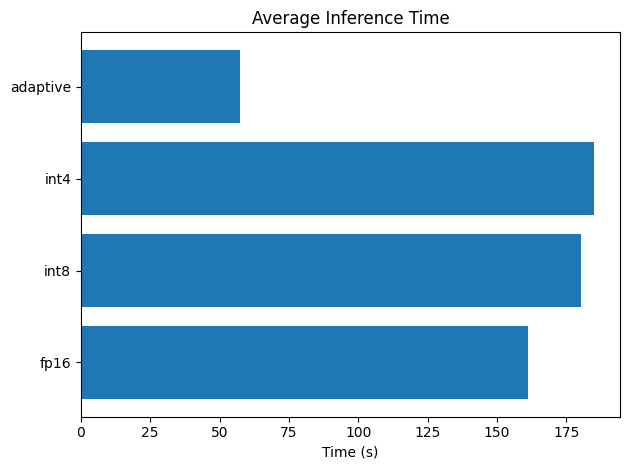

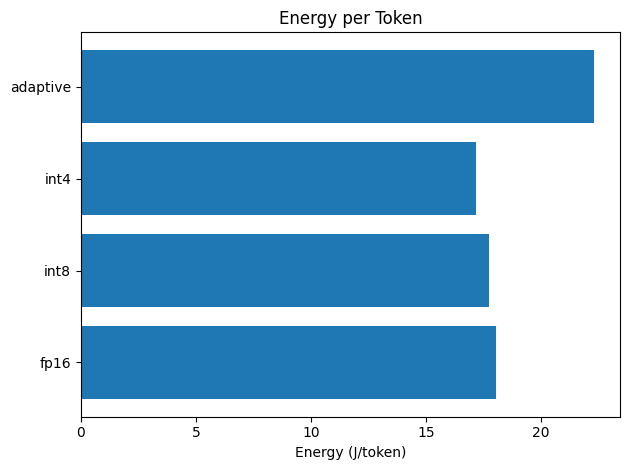

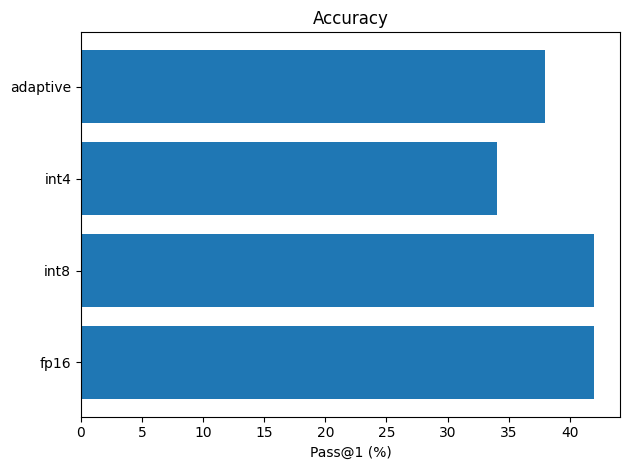

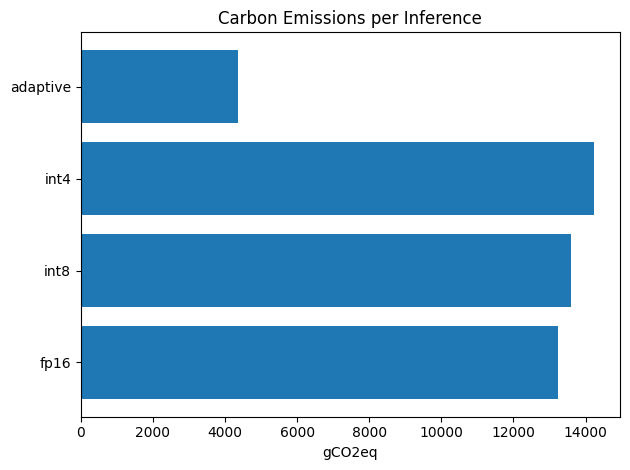

In [23]:
import matplotlib.pyplot as plt

# def compare_quantization_summary(modes = ,summaries, metrics):
# 模型精度模式

# 示例数值（如 Joule/token、accuracy 等）
labels = ['fp16', 'int8', 'int4', 'adaptive']

avg_time = [s['avg_time'] for s in summaries]
energy_token = [s['energy_per_token'] for s in summaries]
accuracy = [s['accuracy'] for s in summaries]
carbon = [s['carbon_emissions'] for s in summaries]

# 绘图函数
def plot_horizontal_bar(data, title, xlabel):
    plt.figure()
    plt.barh(labels, data)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_horizontal_bar(avg_time, 'Average Inference Time', 'Time (s)')
plot_horizontal_bar(energy_token, 'Energy per Token', 'Energy (J/token)')
plot_horizontal_bar(accuracy, 'Accuracy', 'Pass@1 (%)')
plot_horizontal_bar(carbon, 'Carbon Emissions per Inference', 'gCO2eq')

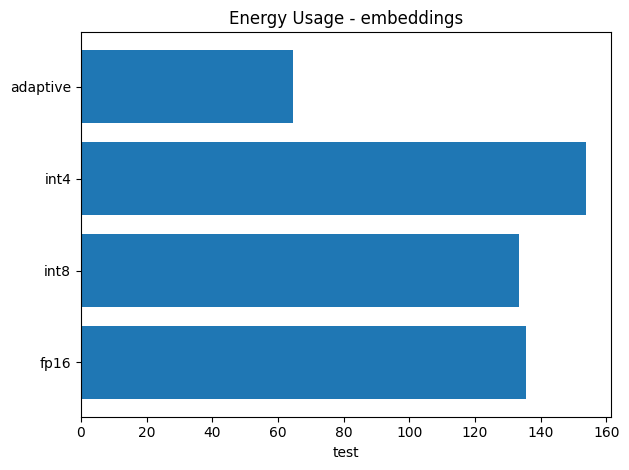

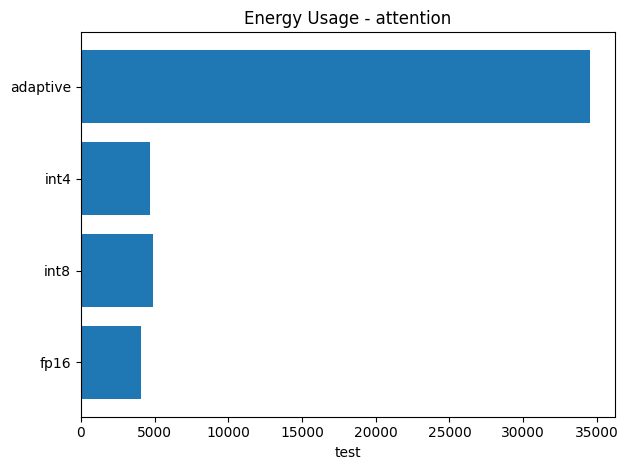

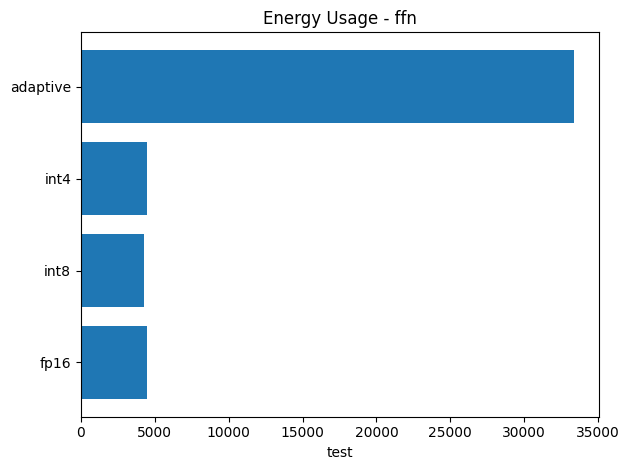

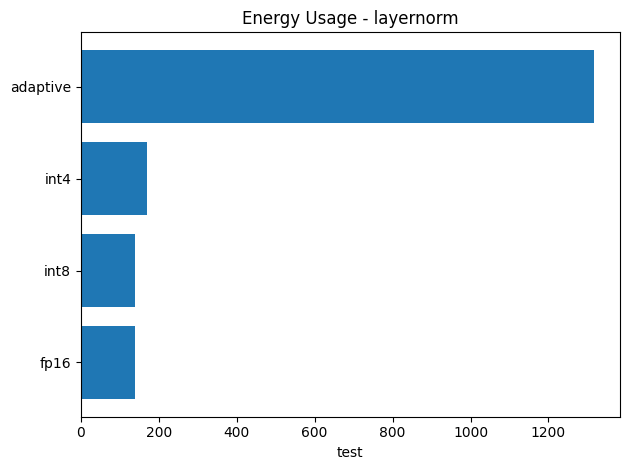

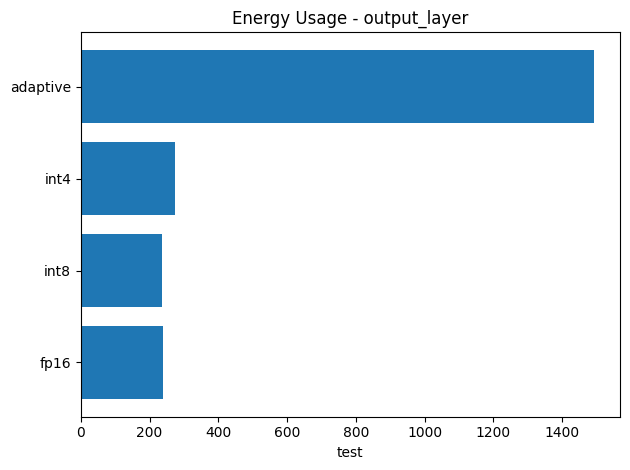

In [31]:
components = [
    {'embeddings': 135.6135982608201, 'attention': 4071.2838841799316, 'ffn': 4509.345964727682, 'layernorm': 137.85207582097615, 'output_layer': 239.47538887404764},
{'embeddings': 133.38215853021433, 'attention': 4888.351678749229, 'ffn': 4256.343064446152, 'layernorm': 138.90935157896482, 'output_layer': 236.92674505380222},
{'embeddings': 153.823048670955, 'attention': 4704.338310226852, 'ffn': 4466.951109296789, 'layernorm': 168.95584720001824, 'output_layer': 274.35684257152474},
{'embeddings': 1294.3433370703754, 'attention': 34513.4544156588, 'ffn': 33381.592672429644, 'layernorm': 1317.6995399442594, 'output_layer': 1493.3569480205288},
]

labels = ['fp16', 'int8', 'int4', 'adaptive']

# 所有模块的名字
modules = ['embeddings', 'attention', 'ffn', 'layernorm', 'output_layer']

# 提取每个模块在4种模式下的能耗
def get_module_values(module):
    return [comp[module] for comp in components]

# 绘制函数
# def plot_component_bar(data, title):
#     plt.figure()
#     plt.barh(labels, data)
#     plt.xlabel("Energy (J)")
#     plt.title(title)
#     plt.tight_layout()
#     plt.show()

# 为每个模块画图
for module in modules:
    values = get_module_values(module)
    plot_horizontal_bar(values, f"Energy Usage - {module}", "test")